### L4 Demo 4 - Facial Recognition

##### Importing Useful Python Libraries or Packages

In [1]:
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw


In [2]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

##### Accessing Specific Azure Resources

In [3]:
FACE_SERV_KEY = "-------------------------------------"
FACE_SERV_ENDPOINT = "https://------------------------.cognitiveservices.azure.com/"

In [4]:
# Create a client
face_client = FaceClient(FACE_SERV_ENDPOINT, CognitiveServicesCredentials(FACE_SERV_KEY))

In [5]:
face_client.api_version

'1.0'

##### These four images are stored in this workspace environment.

In [6]:
!ls vp*.jpg

vp1.jpg  vp2.jpg  vp3.jpg  vp4.jpg  vp5.jpg


In [7]:
my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("vp")]
print(my_face_images)

['vp3.jpg', 'vp5.jpg', 'vp2.jpg', 'vp1.jpg', 'vp4.jpg']


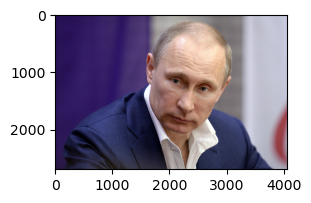

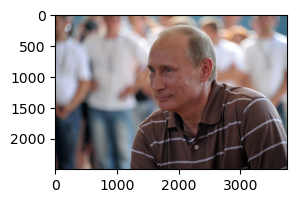

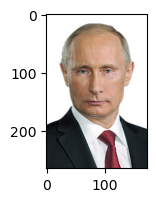

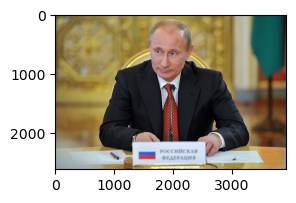

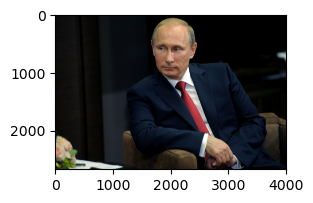

In [8]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure(figsize=(3,2))
        plt.imshow(img_view_ready)

- https://github.com/Azure-Samples/cognitive-services-quickstart-code/blob/master/python/Face/DetectIdentifyFace.py

### Creating A Person Model Based on the 4 Faces

In [9]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'vlad-put'

In [10]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("vp")]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [11]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: eb166ed4-b967-4c80-877e-689239326dca
Training status: running.
Training status: succeeded.


### Making sure the person model has faces and they all belong to the same person

- We detect all faces in query image list, then add their face IDs to a new list.
- this face id list will be used later.

In [12]:
'''
Detect all faces in query image list, then add their face IDs to a new list.
'''
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [13]:
test_images = [file for file in glob.glob('*.jpg') if file.startswith("vp")]

In [14]:
test_images

['vp3.jpg', 'vp5.jpg', 'vp2.jpg', 'vp1.jpg', 'vp4.jpg']

### Now let's view the face-specific thumbnails 

In [15]:
ids = detect_faces(face_client, test_images)

Detecting faces in query images list...
Opening image:  vp3.jpg
Face ID d6c14d06-a2d0-48f9-ac56-c0323d9e0f6b found in image vp3.jpg
Opening image:  vp5.jpg
Face ID 9f08a9c9-09e1-4e9a-a99d-3a31b83ad700 found in image vp5.jpg
Opening image:  vp2.jpg
Face ID ac602d44-d433-49e5-9f4b-0beb4189ee13 found in image vp2.jpg
Opening image:  vp1.jpg
Face ID 33b043bb-e00f-45e8-9853-8181151e31e2 found in image vp1.jpg
Opening image:  vp4.jpg
Face ID 544bf857-bb79-423f-b7c1-0912214ff151 found in image vp4.jpg


In [16]:
ids

{'vp3.jpg': 'd6c14d06-a2d0-48f9-ac56-c0323d9e0f6b',
 'vp5.jpg': '9f08a9c9-09e1-4e9a-a99d-3a31b83ad700',
 'vp2.jpg': 'ac602d44-d433-49e5-9f4b-0beb4189ee13',
 'vp1.jpg': '33b043bb-e00f-45e8-9853-8181151e31e2',
 'vp4.jpg': '544bf857-bb79-423f-b7c1-0912214ff151'}

#### Verify that 2 random images from the list belong to the same person
- ##### Note: So far, we have not used the face recognition part, only face detection

In [17]:
# Verification example for faces of the same person.
verify_result = face_client.face.verify_face_to_face(ids[test_images[0]], ids[test_images[2]])

In [18]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.74573.


### Matching face from URL "internet" with face in our inventory

In [19]:
def show_image_in_cell(face_url):
    response = requests.get(face_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(3,2))
    plt.imshow(img)
    plt.show()

In [22]:
dl_source_url = 'https://ca-times.brightspotcdn.com/dims4/default/1111158/2147483647/strip/true/crop/4246x2620+0+0/resize/1200x740!/format/webp/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F20%2F8a%2F7536916847c78f188f61e12f95a3%2Fukraine-tensions-12214.jpg'

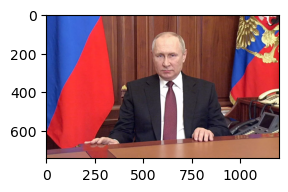

In [23]:
show_image_in_cell(dl_source_url)

In [ ]:
## -------
## Reading file locally
## -------
# If I had image file locally, I would have used the following method:
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [24]:
dl_faces = face_client.face.detect_with_url(dl_source_url) 

### Viewing Face ID and then saving it into the list of already saved Face IDs

In [25]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['vp-from-url.jpg'] = face.face_id

Face ID 7f681df4-7acd-4602-90e4-51d06933bad2 found in image https://ca-times.brightspotcdn.com/dims4/default/1111158/2147483647/strip/true/crop/4246x2620+0+0/resize/1200x740!/format/webp/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F20%2F8a%2F7536916847c78f188f61e12f95a3%2Fukraine-tensions-12214.jpg


##### Now we have 4 + 1 = 5 Face IDs in our face ID list

In [26]:
ids

{'vp3.jpg': 'd6c14d06-a2d0-48f9-ac56-c0323d9e0f6b',
 'vp5.jpg': '9f08a9c9-09e1-4e9a-a99d-3a31b83ad700',
 'vp2.jpg': 'ac602d44-d433-49e5-9f4b-0beb4189ee13',
 'vp1.jpg': '33b043bb-e00f-45e8-9853-8181151e31e2',
 'vp4.jpg': '544bf857-bb79-423f-b7c1-0912214ff151',
 'vp-from-url.jpg': '7f681df4-7acd-4602-90e4-51d06933bad2'}

### Perform Face Verification between the Face ID from the URL and one of the Face IDs from the inventory

In [39]:
# Verification example for faces of the same person.
dl_verify_result = face_client.face.verify_face_to_face(ids[test_images[4]], ids['vp-from-url.jpg'])

In [40]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.76373.


In [41]:
ids['vp-from-url.jpg']

'7f681df4-7acd-4602-90e4-51d06933bad2'

In [42]:
ids.values()

dict_values(['d6c14d06-a2d0-48f9-ac56-c0323d9e0f6b', '9f08a9c9-09e1-4e9a-a99d-3a31b83ad700', 'ac602d44-d433-49e5-9f4b-0beb4189ee13', '33b043bb-e00f-45e8-9853-8181151e31e2', '544bf857-bb79-423f-b7c1-0912214ff151', '7f681df4-7acd-4602-90e4-51d06933bad2'])

In [43]:
dl_faces[0].face_rectangle.as_dict()

{'width': 155, 'height': 155, 'left': 544, 'top': 175}

In [44]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [45]:
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

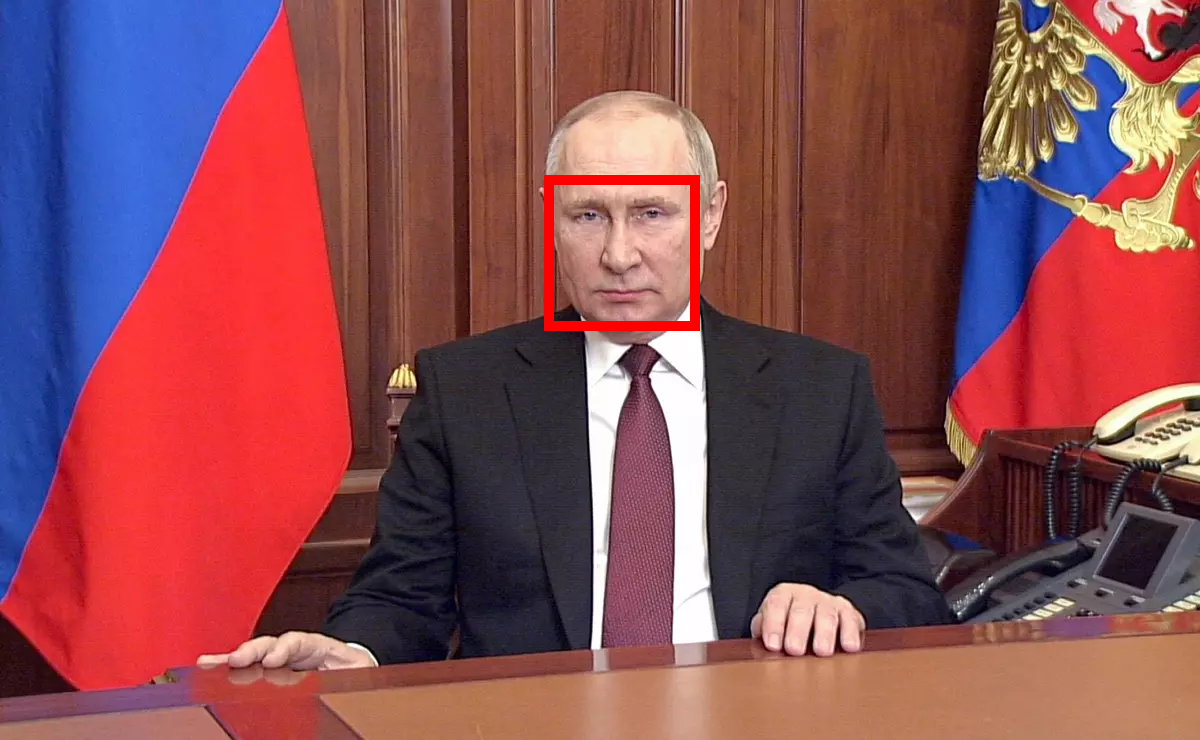

In [46]:
drawFaceRectangles(dl_source_url, dl_faces)

### Matching Face ID from URL with Person Model 

In [47]:
# A list of Face ID
ids

{'vp3.jpg': 'd6c14d06-a2d0-48f9-ac56-c0323d9e0f6b',
 'vp5.jpg': '9f08a9c9-09e1-4e9a-a99d-3a31b83ad700',
 'vp2.jpg': 'ac602d44-d433-49e5-9f4b-0beb4189ee13',
 'vp1.jpg': '33b043bb-e00f-45e8-9853-8181151e31e2',
 'vp4.jpg': '544bf857-bb79-423f-b7c1-0912214ff151',
 'vp-from-url.jpg': '7f681df4-7acd-4602-90e4-51d06933bad2'}

### Using the face ID from the URL and matching the identity with the Person Group model

In [48]:
# Enter the face ID of vp-from-url.jpg from the output of the cell above
get_the_face_id_from_the_url = '7f681df4-7acd-4602-90e4-51d06933bad2'

In [49]:
person_gp_results = face_client.face.identify([get_the_face_id_from_the_url], PERSON_GROUP_ID)

In [50]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.77056
